### Import libraries

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

### Import data

In [2]:
with open(r'config.yml') as file:
    val = yaml.load(file, Loader=yaml.FullLoader)

In [3]:
data = pd.read_csv("BankChurners_Trans.csv")

### Feature Selection

#### Highly Correlated variables

In [4]:
numerical_data = data[val['numerical_variables']]

In [5]:
columns = numerical_data.columns
correlation = numerical_data.corr().values
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        if abs(correlation[i, j]) >= 0.7:
            print(columns[i], columns[j], correlation[i, j])

Customer_Age Months_on_book 0.7889123589930555
Credit_Limit Avg_Open_To_Buy 0.9959805439320076
Total_Trans_Amt Total_Trans_Ct 0.8071920346514353


In [6]:
correlated_variables = ["Months_on_book", "Avg_Open_To_Buy", "Total_Trans_Ct"]

In [7]:
data_1 = data.drop(correlated_variables, axis=1)

In [8]:
x_data = data_1.drop("Attrition_Flag", axis=1)
y_data = data_1["Attrition_Flag"]

#### Lasso Regression

In [9]:
model = LogisticRegression(penalty="l1", solver="liblinear")
skf = StratifiedKFold(n_splits=15, shuffle=True)
results = []
for train_index, test_index in skf.split(x_data, y_data):
    X_train, X_test = x_data.loc[train_index], x_data.loc[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1 = f1_score(y_test, pred)
    results.append(f1)

In [10]:
print(f'Average F1-Score: {round(np.mean(results), 2)}')

Average F1-Score: 0.55


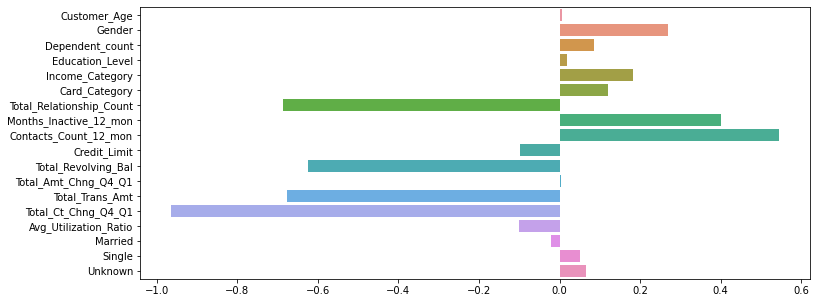

In [11]:
plt.figure(figsize=(12, 5))
sns.barplot(y=x_data.columns, x=model.coef_[0]);

#### Trees

In [12]:
model = RandomForestClassifier(n_estimators=150)
skf = StratifiedKFold(n_splits=15, shuffle=True)
results = []
for train_index, test_index in skf.split(x_data, y_data):
    X_train, X_test = x_data.loc[train_index], x_data.loc[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1 = f1_score(y_test, pred)
    results.append(f1)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       566
           1       0.87      0.76      0.81       109

    accuracy                           0.94       675
   macro avg       0.91      0.87      0.89       675
weighted avg       0.94      0.94      0.94       675



In [13]:
print(f'Average F1-Score: {round(np.mean(results), 2)}')

Average F1-Score: 0.83


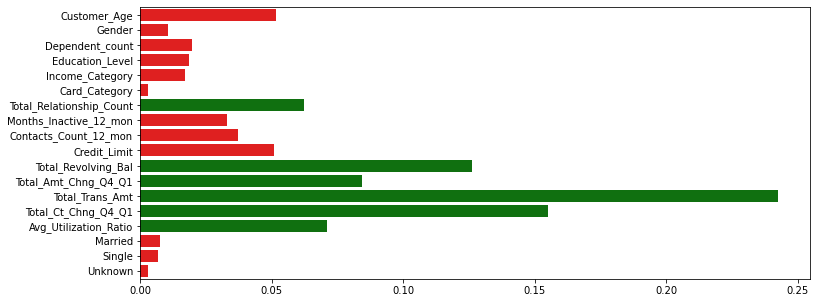

In [14]:
mean_feature_importance = model.feature_importances_.mean()
palette = ['green' if val > mean_feature_importance else 'red' for val in model.feature_importances_]
plt.figure(figsize=(12, 5))
sns.barplot(y=x_data.columns, x=model.feature_importances_, palette=palette);